# Mutational signatures at RNA level
Here, we trace the transitions back to the RNA level.

In [1]:
!mkdir -p figs/univariate/rna/

In [2]:
from glob import glob
from tempfile import TemporaryDirectory
import warnings

from matplotlib import pyplot as plt
from numpy import median
from pandas import DataFrame, Series, concat, read_csv
from scipy.stats import fisher_exact, ks_2samp, wilcoxon
from statkit.views import format_p_value
import seaborn as sns
import vcfpy

In [3]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

In [4]:
from src.dataset import ARTIFACT_DIR
from src.dataset.hartwig import load_hartwig
from src.feature_extraction import COSMIC_MUTATIONAL_SIGNATURES
from src.feature_extraction.rna import TPM, extract_rna_vcf_spectrum
from src.feature_extraction.step1.filter_vcf import filter_synonymous_variants, get_annotations
from src.plot import plot_pvalue
from src.utils import pyrimidine_doublet_base_substitution, pyrimidine_single_base_substitution, quantile_threshold

from utils import polish_variable_names

In [5]:
# Unit test: verify that synonymous variants are filtered.
rna_spectrum = extract_rna_vcf_spectrum(ARTIFACT_DIR / 'vcf_RNA' / 'CPCT02020485T.rna.vcf')
pos = (rna_spectrum.chrom == '22') & (rna_spectrum.pos == 37851338)
assert len(rna_spectrum[pos]) == 0

INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 instead
INFO DP not found using Integer/1 

In [6]:
def filter_by_signature(spectrum: DataFrame, signature, quantile: float = 0.5, invert: bool = False) -> DataFrame:
    """Select all variants that can be ascribed to the given signature.
    
    Args:
        quantile: Select dominant transitions that make up, in total,
            this amount of all the transitions.
        invert: Invert selection.
    """
    threshold = quantile_threshold(signature, quantile)
    transitions = signature[signature > threshold].index
    if invert:
        return spectrum[~spectrum.spectrum.isin(transitions)].copy()
    return spectrum[spectrum.spectrum.isin(transitions)].copy()


def extract_mutated_rna(vcf_pattern: str, X_tpm: DataFrame, tumor_purity: Series, spectrum_filter=None) -> DataFrame:
    """Estimate number of mutant transcripts for mutations in VCF file.
    
    Args:
        vcf_pattern: Select all VCF files matching the glob pattern.
        X_tpm: Transcripts per million estimates.
        spectrum_filter: Method to filter variants.
        tumor_purity: Amount of tumor content of sample, used to 
            renormalize sample to 100 % purity.
    """
    index = []
    features = []
    

    for vcf_file in glob(vcf_pattern):
        # For example: CPCT02020429T.rna.vcf => HRTW_CPCT02020429T.
        patient_id = 'HRTW_' + vcf_file.split('.rna.vcf')[0].split('/')[-1]

        if patient_id not in X_tpm.index:
            print(f'Skipping {patient_id} (not in TPM matrix).')
            continue
        
        # Suppress vcfpy warning about empty DP field.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X_spectrum = extract_rna_vcf_spectrum(vcf_file)

        unknown_transcripts = set(X_spectrum.transcript) - set(X_tpm.columns)
        if len(unknown_transcripts) > 0:
            print('Discarding unknown transcripts', unknown_transcripts)
            X_spectrum = X_spectrum[~X_spectrum.transcript.isin(unknown_transcripts)]

        # Apply filter if necessary.
        if spectrum_filter is not None:
            X_spectrum = spectrum_filter(X_spectrum)
        
        n_variants = X_spectrum['transcript'].unique().size
        average_coverage = X_spectrum['n_depth'].mean()

        # Estimate number of transcripts of mutations in `X_spectrum`.
        n_transcripts = total_mutated_transcripts(
            X_tpm.loc[patient_id], 
            X_spectrum, 
            tumor_purity[patient_id], 
        )
        
        
        index.append(patient_id)
        features.append([n_transcripts, n_variants, average_coverage])
    return DataFrame(features, columns=['n_transcripts', 'n_variants', 'average_coverage'], index=index)


def total_mutated_transcripts(x_tpm, x_vcf, tumor_purity) -> Series:
    """Estimate number of mutant transcript of a single sample."""
    # Multiple (tandem) variants in same transcript: pool by averaging.
    x_vaf = x_vcf.groupby('transcript').mean()['vaf']
    # Only keep variants with detected transcripts.
    x_vaf = x_vaf[x_vaf > 0]

    enrichment = x_vaf / tumor_purity
    # Estimate amount of mutants per transcript.
    mutant_transcripts = enrichment * x_tpm[x_vaf.index]
    # Combine everything.
    return mutant_transcripts.sum()

In [7]:
sbs_signature = read_csv(COSMIC_MUTATIONAL_SIGNATURES['single_base_substitutions'], sep='\t', index_col=0)
dbs_signature = read_csv(COSMIC_MUTATIONAL_SIGNATURES['doublet_base_substitutions'], sep='\t', index_col=0)

sbs4 = sbs_signature['SBS4']
sbs87 = sbs_signature['SBS87']

In [8]:
dataset = load_hartwig()
dataset = polish_variable_names(dataset)

In [9]:
has_y = dataset['Durable benefit'].notna()
rna_pass = dataset['rna_quality_pass'] == 1
dataset = dataset[rna_pass & has_y]

In [10]:
X_counts = read_csv("../artifacts/htseq-counts.tsv", index_col=0, sep="\t")
X_counts = X_counts.drop(columns="gene").sort_index().transpose()
# Add HRTW_ prefix.
X_counts.index = X_counts.index.map(lambda x: "HRTW_" + x.split("_")[0])

# Remove subjects not in our filtered cohort.
subject_with_rna = set(X_counts.index).intersection(dataset.index)
X_counts = X_counts.loc[list(subject_with_rna)]

X_tpm = TPM(
    "../src/feature_extraction/resources/gene_length_gencode.v36.tsv", aggregate=None
).fit_transform(X_counts)

# Strip Ensemble version suffix.
X_tpm.columns = X_tpm.columns.map(lambda x: x.split(".")[0])


# Bias check
Our subanalysis may be biased if some of the variables, such as the target label (outcome) or the features (the  signatures) in our subcohort differ from our entire set.

In [11]:
signature_assignment = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
X_signature = polish_variable_names(signature_assignment)
in_subanalysis = X_signature.index.isin(X_tpm.index)
y = X_signature.loc[in_subanalysis, 'Durable benefit']
y_no_rna = X_signature.loc[~in_subanalysis, 'Durable benefit']

## Target label bias

In [12]:
table = concat([y.dropna().value_counts(), y_no_rna.dropna().value_counts()], axis='columns')

In [13]:
_, p_value = fisher_exact(table.to_numpy())
print(format_p_value(p_value, latex=True, symbol='p', format='compact'), 'Fisher exact test')

$p = 0.67$ Fisher exact test


## Signature bias
Verify that there is no significant differences between the three signatures of interst in the RNA subset and the remainder.

In [14]:
ks_2samp(X_signature.loc[in_subanalysis, 'SBS4'], X_signature.loc[~in_subanalysis, 'SBS4'])

KstestResult(statistic=0.19316239316239317, pvalue=0.30155298176288187)

In [15]:
ks_2samp(X_signature.loc[in_subanalysis, 'SBS87'], X_signature.loc[~in_subanalysis, 'SBS87'])

KstestResult(statistic=0.19829059829059828, pvalue=0.27698109526791914)

# Univariate analysis of RNA

In [16]:
def plot_swarm(values, condition, labels=['No', 'Yes'], ax=None, alternative='two-sided'):
    x_pos = values[condition == labels[1]]
    x_neg = values[condition == labels[0]]
    stat, p_value = ks_2samp(x_neg, x_pos, alternative=alternative)
    
    print(format_p_value(p_value, latex=False, format='compact'))
    
    if ax is None:
        ax = plt.gca()
    
    if values.max() > 1000:
        sns.swarmplot(y=values / 1000, x=condition, order=labels, ax=ax)
        ax.set_ylabel(ax.get_ylabel() + r' ($\times 1000$)')
        plot_pvalue(x_values=[0,1], y_values=values / 1000, pvalue=p_value, ax=ax)
    else:
        sns.swarmplot(y=values, x=condition, order=labels, ax=ax)
        plot_pvalue(x_values=[0,1], y_values=values, pvalue=p_value, ax=ax)
    return ax

In [17]:
print('Number of patients with DNA + RNA + target label: n =', y[y.notna()].size)

Number of patients with DNA + RNA + target label: n = 36


# Total RNA expression
Here we pool all variants and compute the total number of RNA molecules.
We compare these per outcome.

In [18]:
X_rna_all = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=None,
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

Patients with durable benefit have more transcripts with mutations.

In [19]:
print('Average RNA coverage of all variants:', X_rna_all['average_coverage'].mean(),'+/-', X_rna_all['average_coverage'].std())

Average RNA coverage of all variants: 19.772472454502353 +/- 8.77535668743097


In [20]:
plt.figure(figsize=(2, 3))
plot_swarm(X_rna_all.loc[y.notna(), 'n_transcripts'], y[y.notna()], alternative='two-sided')
plt.ylabel(r'TPM  ($\times 1000$)')
plt.savefig('figs/univariate/rna/total.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/total.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/total.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/total.svg', bbox_inches = "tight")

0.018


While patients with durable benefit have, in total, more transcripts. Per mutation, it is about the same.

In [21]:
plt.figure(figsize=(2, 3))

expr_per_variant = X_rna_all.loc[y.notna(), 'n_transcripts'] / X_rna_all.loc[y.notna(), 'n_variants']
plot_swarm(expr_per_variant, y[y.notna()], alternative='two-sided')
plt.ylabel('TPM per variant')
plt.ylim([-0.25, 30])
plt.savefig('figs/univariate/rna/total-normalised.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/total-normalised.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/total-normalised.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/total-normalised.svg', bbox_inches = "tight")

0.81


# SBS4

In [22]:
X_rna_sbs4 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=lambda x: filter_by_signature(x, sbs4)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

0.0036


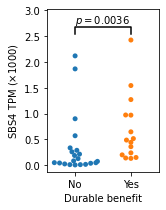

In [23]:
plt.figure(figsize=(2, 3))
plot_swarm(X_rna_sbs4.loc[y.notna(), 'n_transcripts'], y[y.notna()], alternative='two-sided')
plt.ylabel(r'SBS4 TPM ($\times 1000$)')

plt.savefig('figs/univariate/rna/sbs4.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4.svg', bbox_inches = "tight")

0.40


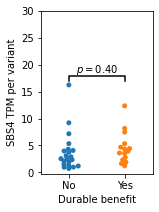

In [24]:
plt.figure(figsize=(2, 3))

expr_per_variant = X_rna_sbs4.loc[y.notna(), 'n_transcripts'] / X_rna_sbs4.loc[y.notna(), 'n_variants']
plot_swarm(expr_per_variant, y[y.notna()], alternative='two-sided')
plt.ylabel('SBS4 TPM per variant')
plt.ylim([-0.25, 30])

plt.savefig('figs/univariate/rna/sbs4-normalised.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-normalised.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-normalised.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-normalised.svg', bbox_inches = "tight")

## SBS87

In [25]:
X_rna_sbs87 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=lambda x: filter_by_signature(x, sbs87)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

0.11


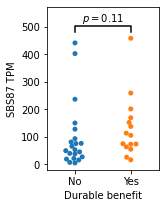

In [26]:
plt.figure(figsize=(2, 3))
plot_swarm(X_rna_sbs87.loc[y.notna(), 'n_transcripts'], y[y.notna()], alternative='two-sided')
plt.ylabel('SBS87 TPM')
plt.savefig('figs/univariate/rna/sbs87.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87.svg', bbox_inches = "tight")

In [27]:
plt.figure(figsize=(2., 3))

expr_per_variant = X_rna_sbs87.loc[y.notna(), 'n_transcripts'] / X_rna_sbs87.loc[y.notna(), 'n_variants']
plot_swarm(expr_per_variant, y[y.notna()], alternative='two-sided')
plt.ylabel('SBS87 TPM per variant')
plt.ylim([-0.25, 30])
plt.savefig('figs/univariate/rna/sbs87-normalised.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87-normalised.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87-normalised.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87-normalised.svg', bbox_inches = "tight")

0.48


Are the number of transcripts in SBS4 larger than SBS87?

In [28]:
w, p = wilcoxon(X_rna_sbs4['n_transcripts'] - X_rna_sbs87['n_transcripts'])
format_p_value(p, symbol='p', format='compact')

'$p = 8.7 \\cdot 10^{-6}$'

In [29]:
w, p = wilcoxon(X_rna_sbs4['n_transcripts']/X_rna_sbs4['n_variants'] - X_rna_sbs87['n_transcripts']/X_rna_sbs87['n_variants'])
format_p_value(p, symbol='p', format='compact')

'$p = 0.093$'

## Any of SBS4 or SBS87

Transcripts in either of:
- SBS4
- SBS87

Is there any commonality from these variants?

In [30]:
X_rna_sbs4_87 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=lambda x: filter_by_signature(x, sbs4 + sbs87)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

In [31]:
print('Average RNA coverage of SBS4 or SBS87 variants:', X_rna_sbs4_87['average_coverage'].mean(),'+/-', X_rna_sbs4_87['average_coverage'].std())

Average RNA coverage of SBS4 or SBS87 variants: 19.127252077258103 +/- 10.536904554195043


In [32]:
plt.figure(figsize=(2.5, 3))

ax = plot_swarm(X_rna_sbs4_87.loc[y.notna(), 'n_transcripts'], y[y.notna()], labels=['No', 'Yes'], alternative='two-sided')
ax.set_ylabel(r'SBS4/SBS87 TPM ($\times 1000$)')

0.021


Text(0, 0.5, 'SBS4/SBS87 TPM ($\\times 1000$)')

0.11


Text(0, 0.5, 'SBS4/SBS87 TPM per variant')

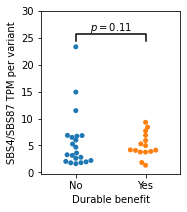

In [33]:
plt.figure(figsize=(2.5, 3))

expr_per_variant = (
    X_rna_sbs4_87.loc[y.notna(), "n_transcripts"]
    / X_rna_sbs4_87.loc[y.notna(), "n_variants"]
)
plot_swarm(
    expr_per_variant, y[y.notna()], labels=["No", "Yes"], alternative="two-sided"
)
plt.ylim([-0.25, 30])
plt.ylabel("SBS4/SBS87 TPM per variant")


## Any of SBS4 and SBS87
This analysis is the exact oposite of the previous analysis:
Transcripts explicitly **_not_** in:
- SBS4
- SBS87

In [34]:
# Keep substitutions in any of the three.    
X_rna_not_sbs4_87 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    # Invert filter.
    spectrum_filter=lambda x: filter_by_signature(x, sbs4 + sbs87, invert=True)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

0.0023


Text(0, 0.5, 'Non-SBS4/SBS87 transcripts  ($\\times 1000$)')

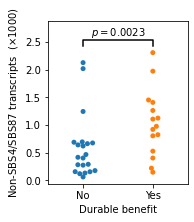

In [35]:
plt.figure(figsize=(2.5, 3))

plot_swarm(X_rna_not_sbs4_87.loc[y.notna(), 'n_transcripts'], y[y.notna()], labels=['No', 'Yes'], alternative='two-sided')
plt.ylabel(r'Non-SBS4/SBS87 transcripts  ($\times 1000$)')

In [36]:
plt.figure(figsize=(2.5, 3))

expr_per_variant = X_rna_not_sbs4_87.loc[y.notna(), 'n_transcripts'] / X_rna_not_sbs4_87.loc[y.notna(), 'n_variants']
plot_swarm(expr_per_variant, y[y.notna()], labels=['No', 'Yes'], alternative='two-sided')
plt.ylim([-0.25, 30])
plt.ylabel('Non-SBS4/SBS87 TPM per variant')

0.52


Text(0, 0.5, 'Non-SBS4/SBS87 TPM per variant')

# Distinguishing characteristics of SBS4 and SBS87

**Question**: Comparing the number of transcripts per varaint:
- from SBS4/SBS87
- from all else,

Is there any difference between the two groups? If so, this might suggest that SBS4/SBS87 RNA (i) is more stable (ii) or more actively produced.

In [37]:
X_rna_not_sbs87 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=lambda x: filter_by_signature(x, sbs87, invert=True)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

In [38]:
X_rna_not_sbs4 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=lambda x: filter_by_signature(x, sbs4, invert=True)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

In [39]:
def plot_swarm_comparison(X_rna_left, X_rna_right, labels):
    X_a_norm = X_rna_left['n_transcripts'] / X_rna_left['n_variants']
    X_b_norm = X_rna_right['n_transcripts'] / X_rna_right['n_variants']
    y_tpm = concat([X_a_norm, X_b_norm])
    x_labels = concat([X_a_norm*0, X_b_norm*0+1]).replace({0.0: labels[0], 1.0: labels[1]})

    plt.figure(figsize=(2.5, 3))
    plot_swarm(y_tpm, x_labels, labels=labels, alternative='two-sided')
    plt.ylabel('TPM per variant')
    plt.ylim([-0.25, 30])

Boolean Series key will be reindexed to match DataFrame index.


0.34


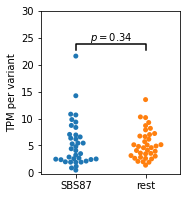

In [40]:
plot_swarm_comparison(X_rna_sbs87[y.notna()], X_rna_not_sbs87[y.notna()], labels=['SBS87', 'rest'])
plt.savefig('figs/univariate/rna/sbs87-vs-rest.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87-vs-rest.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87-vs-rest.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs87-vs-rest.svg', bbox_inches = "tight")

Boolean Series key will be reindexed to match DataFrame index.


0.018


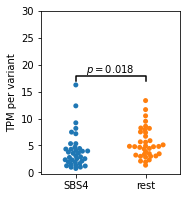

In [41]:
plot_swarm_comparison(X_rna_sbs4[y.notna()], X_rna_not_sbs4[y.notna()], labels=['SBS4', 'rest'])
plt.savefig('figs/univariate/rna/sbs4-vs-rest.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-vs-rest.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-vs-rest.pdf', bbox_inches = "tight")

In [42]:
X_rna_not_sbs4_87 = extract_mutated_rna(
    vcf_pattern='../artifacts/vcf_RNA/*.rna.vcf',
    X_tpm=X_tpm,
    tumor_purity=dataset['tumor_purity'],
    spectrum_filter=lambda x: filter_by_signature(x, sbs4+sbs87, invert=True)
)

Discarding unknown transcripts {'ENSG00000163486'}
Discarding unknown transcripts {'ENSG00000212734', 'ENSG00000267884', 'ENSG00000235878', 'ENSG00000198877', 'ENSG00000243444', 'ENSG00000236294'}
Discarding unknown transcripts {'ENSG00000241978', 'ENSG00000152022', 'ENSG00000257040', 'ENSG00000198877'}
Discarding unknown transcripts {'ENSG00000174942', 'ENSG00000077809', 'ENSG00000163386'}
Discarding unknown transcripts {'ENSG00000197932', 'ENSG00000269121', 'ENSG00000174942', 'ENSG00000244291', 'ENSG00000226974', 'ENSG00000171471', 'ENSG00000267802', 'ENSG00000227184', 'ENSG00000269185', 'ENSG00000213922'}
Discarding unknown transcripts {'ENSG00000267901', 'ENSG00000212734', 'ENSG00000197263', 'ENSG00000176274', 'ENSG00000211671', 'ENSG00000266949', 'ENSG00000243452'}
Discarding unknown transcripts {'ENSG00000145965', 'ENSG00000090920', 'ENSG00000196533', 'ENSG00000268387', 'ENSG00000254667', 'ENSG00000253426', 'ENSG00000204365', 'ENSG00000196936', 'ENSG00000181689', 'ENSG00000186117

0.71


Boolean Series key will be reindexed to match DataFrame index.


<Figure size 180x216 with 0 Axes>

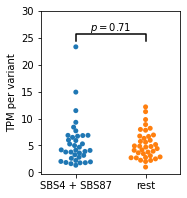

In [43]:
plt.figure(figsize=(2.5, 3))
plot_swarm_comparison(X_rna_sbs4_87[y.notna()], X_rna_not_sbs4_87[y.notna()], labels=['SBS4 + SBS87', 'rest'])

plt.savefig('figs/univariate/rna/sbs4-sbs87-vs-rest.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-sbs87-vs-rest.png', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-sbs87-vs-rest.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/rna/sbs4-sbs87-vs-rest.svg', bbox_inches = "tight")

**Answer**: It is extremely unlikely that the number of transcripts between these signatures is different.

Compare transcripts of mutations in either of our signature versus outside, regardless of outcome